In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency, chi2
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv(r"/Users/priyankamalavade/Desktop/Ecommerce_Performance_Analysis/data/cleaned_ecommerce_data.csv")

In [3]:
# Display basic info about the dataset
print(f"\nDataset Overview:")
print(f"Total Sessions: {len(df):,}")
print(f"Conversion Rate: {df['Revenue'].mean():.4f}")
print(f"Average Revenue: ${df['Revenue'].mean():.2f}")



Dataset Overview:
Total Sessions: 12,330
Conversion Rate: 0.1547
Average Revenue: $0.15


In [4]:
# Check data types and missing values
print(f"\nData Quality Check:")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Unique visitor types: {df['VisitorType'].unique()}")



Data Quality Check:
Missing values: 0
Unique visitor types: ['Returning_Visitor' 'New_Visitor' 'Other']


In [5]:
# Stage 1: All Sessions (Landing Page Views)
stage_1_sessions = len(df)
print(f"Stage 1 - All Sessions: {stage_1_sessions:,}")

# Stage 2: Page Engagement (visited more than just landing page)
# Users who visited Administrative, Informational, or ProductRelated pages
engaged_sessions = df[
    (df['Administrative'] > 0) | 
    (df['Informational'] > 0) | 
    (df['ProductRelated'] > 0)
]
stage_2_engaged = len(engaged_sessions)
print(f"Stage 2 - Engaged Sessions: {stage_2_engaged:,}")

# Stage 3: Product Interest (visited ProductRelated pages)
product_interest = df[df['ProductRelated'] > 0]
stage_3_interest = len(product_interest)
print(f"Stage 3 - Product Interest: {stage_3_interest:,}")

# Stage 4: Deep Product Engagement (multiple product pages or high duration)
deep_engagement = df[
    (df['ProductRelated'] > 2) | 
    (df['ProductRelated_Duration'] > 300)  # 5+ minutes on product pages
]
stage_4_deep = len(deep_engagement)
print(f"Stage 4 - Deep Product Engagement: {stage_4_deep:,}")

# Stage 5: High Intent (PageValues > 0 or low bounce rate)
high_intent = df[
    (df['PageValues'] > 0) | 
    (df['BounceRates'] < 0.02)  # Very low bounce rate
]
stage_5_intent = len(high_intent)
print(f"Stage 5 - High Intent: {stage_5_intent:,}")

# Stage 6: Purchase (Revenue = True)
stage_6_purchase = df['Revenue'].sum()
print(f"Stage 6 - Purchase: {stage_6_purchase:,}")

# Calculate conversion rates
funnel_data = {
    'Stage': ['All Sessions', 'Engaged', 'Product Interest', 'Deep Engagement', 'High Intent', 'Purchase'],
    'Count': [stage_1_sessions, stage_2_engaged, stage_3_interest, stage_4_deep, stage_5_intent, stage_6_purchase],
    'Conversion_Rate': [100, 0, 0, 0, 0, 0],
    'Drop_Off_Rate': [0, 0, 0, 0, 0, 0]
}

# Calculate conversion and drop-off rates
for i in range(1, len(funnel_data['Count'])):
    funnel_data['Conversion_Rate'][i] = (funnel_data['Count'][i] / funnel_data['Count'][0]) * 100
    if i > 0:
        funnel_data['Drop_Off_Rate'][i] = ((funnel_data['Count'][i-1] - funnel_data['Count'][i]) / funnel_data['Count'][i-1]) * 100

funnel_df = pd.DataFrame(funnel_data)
print(f"\nFunnel Summary:")
print(funnel_df.round(2))


Stage 1 - All Sessions: 12,330
Stage 2 - Engaged Sessions: 12,324
Stage 3 - Product Interest: 12,292
Stage 4 - Deep Product Engagement: 11,232
Stage 5 - High Intent: 9,729
Stage 6 - Purchase: 1,908

Funnel Summary:
              Stage  Count  Conversion_Rate  Drop_Off_Rate
0      All Sessions  12330           100.00           0.00
1           Engaged  12324            99.95           0.05
2  Product Interest  12292            99.69           0.26
3   Deep Engagement  11232            91.09           8.62
4       High Intent   9729            78.91          13.38
5          Purchase   1908            15.47          80.39


In [6]:
# Create funnel chart
fig = go.Figure()

fig.add_trace(go.Funnel(
    y=funnel_df['Stage'],
    x=funnel_df['Count'],
    textinfo="value+percent initial",
    textposition="inside",
    textfont=dict(color="white", size=12),
    connector={"line": {"color": "royalblue", "dash": "dot", "width": 3}},
    marker={"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver", "gold"]}
))

fig.update_layout(
    title="E-commerce Conversion Funnel - Real Data Analysis",
    font=dict(size=14),
    width=900,
    height=700
)

fig.show()

In [7]:
def calculate_detailed_funnel_metrics(data):
    """Calculate detailed funnel metrics for a given dataset"""
    total_sessions = len(data)
    engaged = len(data[(data['Administrative'] > 0) | (data['Informational'] > 0) | (data['ProductRelated'] > 0)])
    product_interest = len(data[data['ProductRelated'] > 0])
    deep_engagement = len(data[(data['ProductRelated'] > 2) | (data['ProductRelated_Duration'] > 300)])
    high_intent = len(data[(data['PageValues'] > 0) | (data['BounceRates'] < 0.02)])
    purchase = data['Revenue'].sum()
    
    return {
        'Total_Sessions': total_sessions,
        'Engaged': engaged,
        'Product_Interest': product_interest,
        'Deep_Engagement': deep_engagement,
        'High_Intent': high_intent,
        'Purchase': purchase,
        'Engagement_Rate': (engaged / total_sessions) * 100 if total_sessions > 0 else 0,
        'Product_Interest_Rate': (product_interest / total_sessions) * 100 if total_sessions > 0 else 0,
        'Deep_Engagement_Rate': (deep_engagement / total_sessions) * 100 if total_sessions > 0 else 0,
        'High_Intent_Rate': (high_intent / total_sessions) * 100 if total_sessions > 0 else 0,
        'Conversion_Rate': (purchase / total_sessions) * 100 if total_sessions > 0 else 0,
        'Avg_Page_Value': data['PageValues'].mean(),
        'Avg_Session_Duration': data['Total_Duration'].mean(),
        'Avg_Pages_Per_Session': data['Total_Pages'].mean()
    }


In [9]:
# Analyze by Visitor Type
print("Funnel Analysis by Visitor Type:")
visitor_funnel = {}
for visitor_type in df['VisitorType'].unique():
    visitor_data = df[df['VisitorType'] == visitor_type]
    visitor_funnel[visitor_type] = calculate_detailed_funnel_metrics(visitor_data)

visitor_funnel_df = pd.DataFrame(visitor_funnel).T
visitor_funnel_df.round(2)


Funnel Analysis by Visitor Type:


,Total_Sessions,Engaged,Product_Interest,Deep_Engagement,High_Intent,Purchase,Engagement_Rate,Product_Interest_Rate,Deep_Engagement_Rate,High_Intent_Rate,Conversion_Rate,Avg_Page_Value,Avg_Session_Duration,Avg_Pages_Per_Session
Returning_Visitor,10551.0,10545.0,10520.0,9601.0,8047.0,1470.0,99.94,99.71,91.00,76.27,13.93,5.01,1405.71,36.90
New_Visitor,1694.0,1694.0,1687.0,1573.0,1614.0,422.0,100.00,99.59,92.86,95.28,24.91,10.77,747.54,20.94
Other,85.0,85.0,85.0,58.0,68.0,16.0,100.00,100.00,68.24,80.00,18.82,18.19,644.79,14.12


In [10]:
# Analyze by Month
print("\nFunnel Analysis by Month:")
month_funnel = {}
for month in df['Month'].unique():
    month_data = df[df['Month'] == month]
    month_funnel[month] = calculate_detailed_funnel_metrics(month_data)

month_funnel_df = pd.DataFrame(month_funnel).T
month_funnel_df.round(2)



Funnel Analysis by Month:


,Total_Sessions,Engaged,Product_Interest,Deep_Engagement,High_Intent,Purchase,Engagement_Rate,Product_Interest_Rate,Deep_Engagement_Rate,High_Intent_Rate,Conversion_Rate,Avg_Page_Value,Avg_Session_Duration,Avg_Pages_Per_Session
Nov,2998.0,2995.0,2986.0,2788.0,2494.0,760.0,99.90,99.60,93.00,83.19,25.35,7.13,1892.97,49.30
Mar,1907.0,1907.0,1904.0,1687.0,1534.0,192.0,100.00,99.84,88.46,80.44,10.07,3.96,914.19,22.12
Dec,1727.0,1727.0,1723.0,1552.0,1398.0,216.0,100.00,99.77,89.87,80.95,12.51,6.83,1228.17,30.70
May,3364.0,3362.0,3353.0,3067.0,2462.0,365.0,99.94,99.67,91.17,73.19,10.85,5.43,1078.53,28.88
Aug,433.0,433.0,432.0,407.0,352.0,76.0,100.00,99.77,94.00,81.29,17.55,5.94,1414.89,41.94
Jul,432.0,432.0,432.0,404.0,320.0,66.0,100.00,100.00,93.52,74.07,15.28,4.10,1342.00,39.35
Feb,184.0,184.0,183.0,134.0,122.0,3.0,100.00,99.46,72.83,66.30,1.63,0.89,490.27,11.82
June,288.0,287.0,287.0,258.0,186.0,29.0,99.65,99.65,89.58,64.58,10.07,3.39,1292.96,38.90
Sep,448.0,448.0,447.0,418.0,389.0,86.0,100.00,99.78,93.30,86.83,19.20,7.56,1398.45,37.01
Oct,549.0,549.0,545.0,517.0,472.0,115.0,100.00,99.27,94.17,85.97,20.95,8.65,1281.58,37.77


In [11]:
# Analyze by Weekend vs Weekday
print("\nFunnel Analysis by Weekend vs Weekday:")
weekend_funnel = {}
for weekend in [True, False]:
    weekend_data = df[df['Weekend'] == weekend]
    weekend_label = 'Weekend' if weekend else 'Weekday'
    weekend_funnel[weekend_label] = calculate_detailed_funnel_metrics(weekend_data)

weekend_funnel_df = pd.DataFrame(weekend_funnel).T
weekend_funnel_df.round(2)


Funnel Analysis by Weekend vs Weekday:


,Total_Sessions,Engaged,Product_Interest,Deep_Engagement,High_Intent,Purchase,Engagement_Rate,Product_Interest_Rate,Deep_Engagement_Rate,High_Intent_Rate,Conversion_Rate,Avg_Page_Value,Avg_Session_Duration,Avg_Pages_Per_Session
Weekend,2868.0,2867.0,2855.0,2650.0,2356.0,499.0,99.97,99.55,92.4,82.15,17.40,6.29,1346.42,36.09
Weekday,9462.0,9457.0,9437.0,8582.0,7373.0,1409.0,99.95,99.74,90.7,77.92,14.89,5.77,1299.01,34.08


In [12]:
# Create A/B test groups based on session characteristics
# Group A: Sessions with even Session IDs (if available) or random assignment
np.random.seed(42)
df['AB_Test_Group'] = np.random.choice(['A', 'B'], len(df))


In [14]:
# A/B Testing Analysis
ab_summary = df.groupby('AB_Test_Group').agg({
    'Revenue': ['count', 'sum', 'mean'],
    'PageValues': 'mean',
    'Total_Pages': 'mean',
    'Total_Duration': 'mean',
    'BounceRates': 'mean',
    'ExitRates': 'mean'
}).round(4)

ab_summary.columns = ['Sessions', 'Total_Conversions', 'Conversion_Rate', 'Avg_Page_Value', 
                     'Avg_Pages', 'Avg_Duration', 'Avg_Bounce_Rate', 'Avg_Exit_Rate']
print("A/B Test Summary:")
ab_summary

A/B Test Summary:


,Sessions,Total_Conversions,Conversion_Rate,Avg_Page_Value,Avg_Pages,Avg_Duration,Avg_Bounce_Rate,Avg_Exit_Rate
AB_Test_Group,,,,,,,,
A,6171,921,0.1492,5.3951,34.4294,1295.7280,0.0227,0.0438
B,6159,987,0.1603,6.3843,34.6712,1324.3744,0.0217,0.0423


In [15]:
# Statistical significance testing
group_a = df[df['AB_Test_Group'] == 'A']
group_b = df[df['AB_Test_Group'] == 'B']

# Chi-square test for conversion rate
contingency_table = pd.crosstab(df['AB_Test_Group'], df['Revenue'])
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)


In [16]:
print(f"\nConversion Rate A/B Test:")
print(f"Group A Conversion Rate: {group_a['Revenue'].mean():.4f}")
print(f"Group B Conversion Rate: {group_b['Revenue'].mean():.4f}")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi2:.4f}")
print(f"Statistical significance: {'Yes' if p_value_chi2 < 0.05 else 'No'}")

# T-test for PageValues (proxy for revenue/engagement)
t_stat_pv, p_value_pv = stats.ttest_ind(group_a['PageValues'], group_b['PageValues'])
print(f"\nPage Values A/B Test:")
print(f"Group A Avg Page Value: {group_a['PageValues'].mean():.2f}")
print(f"Group B Avg Page Value: {group_b['PageValues'].mean():.2f}")
print(f"T-statistic: {t_stat_pv:.4f}")
print(f"P-value: {p_value_pv:.4f}")
print(f"Statistical significance: {'Yes' if p_value_pv < 0.05 else 'No'}")



Conversion Rate A/B Test:
Group A Conversion Rate: 0.1492
Group B Conversion Rate: 0.1603
Chi-square statistic: 2.7716
P-value: 0.0960
Statistical significance: No

Page Values A/B Test:
Group A Avg Page Value: 5.40
Group B Avg Page Value: 6.38
T-statistic: -2.9587
P-value: 0.0031
Statistical significance: Yes


In [17]:
# Funnel by Visitor Type
fig_visitor = make_subplots(
    rows=1, cols=len(df['VisitorType'].unique()),
    subplot_titles=list(df['VisitorType'].unique()),
    specs=[[{"type": "funnel"} for _ in range(len(df['VisitorType'].unique()))]]
)

colors = ['lightblue', 'lightgreen', 'lightcoral']
for i, visitor_type in enumerate(df['VisitorType'].unique()):
    visitor_data = visitor_funnel_df.loc[visitor_type]
    
    fig_visitor.add_trace(
        go.Funnel(
            y=['Sessions', 'Engaged', 'Product Interest', 'Deep Engagement', 'High Intent', 'Purchase'],
            x=[visitor_data['Total_Sessions'], visitor_data['Engaged'], 
               visitor_data['Product_Interest'], visitor_data['Deep_Engagement'], 
               visitor_data['High_Intent'], visitor_data['Purchase']],
            name=visitor_type,
            marker_color=colors[i % len(colors)]
        ),
        row=1, col=i+1
    )

fig_visitor.update_layout(
    title="Conversion Funnel by Visitor Type",
    height=500,
    showlegend=False
)
fig_visitor.show()


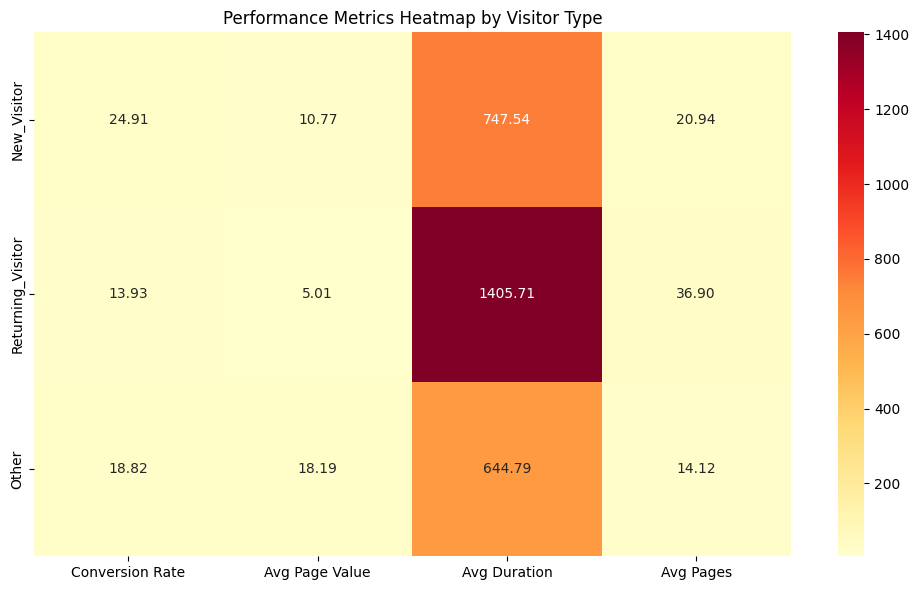

In [18]:
# Create performance matrix
performance_metrics = []
segments = ['New_Visitor', 'Returning_Visitor', 'Other']

for segment in segments:
    if segment in df['VisitorType'].values:
        segment_data = df[df['VisitorType'] == segment]
        metrics = calculate_detailed_funnel_metrics(segment_data)
        performance_metrics.append([
            metrics['Conversion_Rate'],
            metrics['Avg_Page_Value'],
            metrics['Avg_Session_Duration'],
            metrics['Avg_Pages_Per_Session']
        ])

if performance_metrics:
    performance_df = pd.DataFrame(
        performance_metrics,
        index=[seg for seg in segments if seg in df['VisitorType'].values],
        columns=['Conversion Rate', 'Avg Page Value', 'Avg Duration', 'Avg Pages']
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(performance_df, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Performance Metrics Heatmap by Visitor Type')
    plt.tight_layout()
    plt.show()


In [19]:
# Monthly performance
monthly_performance = df.groupby('Month').agg({
    'Revenue': ['count', 'sum', 'mean'],
    'PageValues': 'mean',
    'BounceRates': 'mean',
    'Total_Pages': 'mean'
}).round(4)

monthly_performance.columns = ['Sessions', 'Conversions', 'Conversion_Rate', 'Avg_Page_Value', 'Bounce_Rate', 'Avg_Pages']
print("Monthly Performance:")
print(monthly_performance)

# Weekend vs Weekday analysis
weekend_performance = df.groupby('Weekend').agg({
    'Revenue': ['count', 'sum', 'mean'],
    'PageValues': 'mean',
    'BounceRates': 'mean'
}).round(4)

weekend_performance.columns = ['Sessions', 'Conversions', 'Conversion_Rate', 'Avg_Page_Value', 'Bounce_Rate']
weekend_performance.index = ['Weekday', 'Weekend']
print("\nWeekend vs Weekday Performance:")
print(weekend_performance)


Monthly Performance:
       Sessions  Conversions  Conversion_Rate  Avg_Page_Value  Bounce_Rate  \
Month                                                                        
Aug         433           76           0.1755          5.9381       0.0182   
Dec        1727          216           0.1251          6.8332       0.0201   
Feb         184            3           0.0163          0.8904       0.0470   
Jul         432           66           0.1528          4.1044       0.0247   
June        288           29           0.1007          3.3914       0.0351   
Mar        1907          192           0.1007          3.9597       0.0217   
May        3364          365           0.1085          5.4316       0.0269   
Nov        2998          760           0.2535          7.1294       0.0193   
Oct         549          115           0.2095          8.6456       0.0118   
Sep         448           86           0.1920          7.5568       0.0122   

       Avg_Pages  
Month             
Aug 

In [20]:
# Calculate key metrics
overall_conversion_rate = df['Revenue'].mean() * 100
avg_page_value = df['PageValues'].mean()
avg_bounce_rate = df['BounceRates'].mean() * 100
best_visitor_type = visitor_funnel_df['Conversion_Rate'].idxmax()
best_month = monthly_performance['Conversion_Rate'].idxmax()


In [21]:
print(f"• Overall conversion rate: {overall_conversion_rate:.2f}%")
print(f"• Average page value: ${avg_page_value:.2f}")
print(f"• Average bounce rate: {avg_bounce_rate:.2f}%")
print(f"• Best performing visitor type: {best_visitor_type}")
print(f"• Best performing month: {best_month}")


• Overall conversion rate: 15.47%
• Average page value: $5.89
• Average bounce rate: 2.22%
• Best performing visitor type: New_Visitor
• Best performing month: Nov


In [22]:
total_revenue = df['PageValues'].sum()  # Using PageValues as revenue proxy
revenue_per_session = total_revenue / len(df)
print(f"• Total page value generated: ${total_revenue:.2f}")
print(f"• Revenue per session: ${revenue_per_session:.2f}")


• Total page value generated: $72614.55
• Revenue per session: $5.89


In [23]:
avg_product_pages = df['ProductRelated'].mean()
avg_session_duration = df['Total_Duration'].mean()
print(f"• Average product pages per session: {avg_product_pages:.1f}")
print(f"• Average session duration: {avg_session_duration:.1f} seconds")


• Average product pages per session: 31.7
• Average session duration: 1310.0 seconds


In [24]:
if p_value_chi2 < 0.05:
    winner = 'A' if group_a['Revenue'].mean() > group_b['Revenue'].mean() else 'B'
    print(f"• Statistically significant difference found (p = {p_value_chi2:.4f})")
    print(f"• Group {winner} is the winner for conversion rate")
else:
    print(f"• No statistically significant difference in conversion rates (p = {p_value_chi2:.4f})")


• No statistically significant difference in conversion rates (p = 0.0960)


In [25]:
funnel_df.to_csv('/Users/priyankamalavade/Desktop/Ecommerce_Performance_Analysis/data/funnel_analysis_results.csv', index=False)
visitor_funnel_df.to_csv('/Users/priyankamalavade/Desktop/Ecommerce_Performance_Analysis/data/visitor_type_funnel_analysis.csv')
monthly_performance.to_csv('/Users/priyankamalavade/Desktop/Ecommerce_Performance_Analysis/data/monthly_performance_analysis.csv')
